In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rashikrahmanpritom/plant-disease-recognition-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.25G/1.25G [00:10<00:00, 124MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/versions/1


---
# Visualization

In [ ]:
import os

# List subfolders and files
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:5]:  # show up to 5 files per folder
        print(f"{subindent}{f}")


1/
  Validation/
    Validation/
      Rust/
        8152cfbd5a28b5d2.jpg
        860a8fbf3c6c00fd.jpg
        929b16251fcaafc4.jpg
        885e1bc6a3674eb1.jpg
        955f62896264dbb2.jpg
      Healthy/
        9c527f2a43e07a9c.jpg
        9ccf708985967f09.jpg
        9ccbc2c5d1aaf078.jpg
        9cc33c23b0df68b2.jpg
        9be41b823d13e3c6.jpg
      Powdery/
        8fd27998ae52a4a6.jpg
        8f6737815b2cd234.jpg
        9a96746d61e5c43c.jpg
        9bd06de433b285d8.jpg
        9bae271592e9e4c2.jpg
  Test/
    Test/
      Rust/
        97ae1a31133769cc.jpg
        84c2b48da27b8cf7.jpg
        85f0c2c0db4b4f4f.jpg
        830f26cc6d3cd13e.jpg
        90fcd8e1fb2e003d.jpg
      Healthy/
        8f90e6bbd782c911.jpg
        8f456733d83cc836.jpg
        8fd88738e26f45c4.jpg
        8e82b1a51bd11afe.jpg
        8ddd5ec1c0de38c4.jpg
      Powdery/
        81e5fcf446a9270b.jpg
        85c232ef5da06ab9.jpg
        86c26ddf47b35828.jpg
        87b516b8b82169d7.jpg
        9ed17032dce2f984

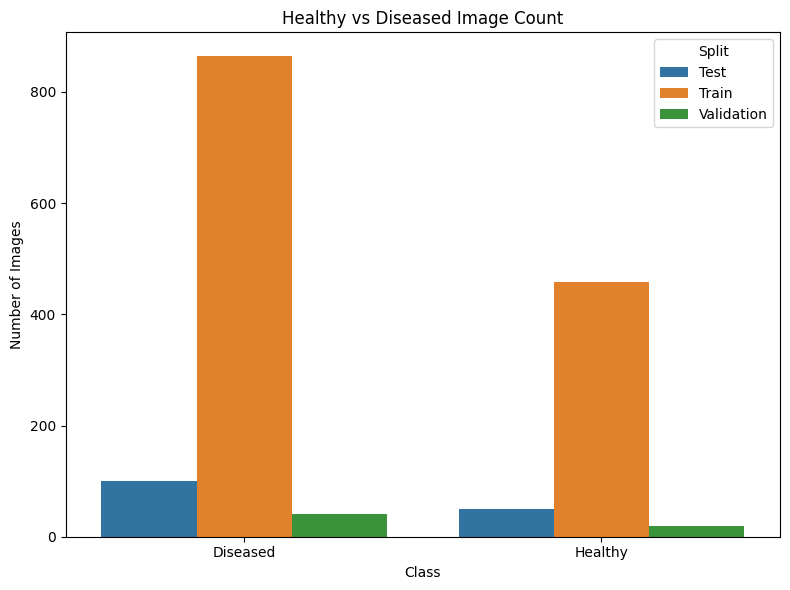

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define categories
healthy_label = "Healthy"
diseased_labels = ["Rust", "Powdery"]
splits = ['Train/Train', 'Test/Test', 'Validation/Validation']

# Count images
binary_counts = []

for split in splits:
    split_name = split.split('/')[0]
    for cls in [healthy_label] + diseased_labels:
        cls_path = os.path.join(path, split, cls)
        count = len(os.listdir(cls_path)) if os.path.exists(cls_path) else 0
        label = "Healthy" if cls == healthy_label else "Diseased"
        binary_counts.append({"Split": split_name, "Label": label, "Count": count})

# Convert to DataFrame
df_bin = pd.DataFrame(binary_counts)
df_bin_grouped = df_bin.groupby(["Split", "Label"]).sum().reset_index()

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=df_bin_grouped, x="Label", y="Count", hue="Split")
plt.title("Healthy vs Diseased Image Count")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.tight_layout()
plt.show()


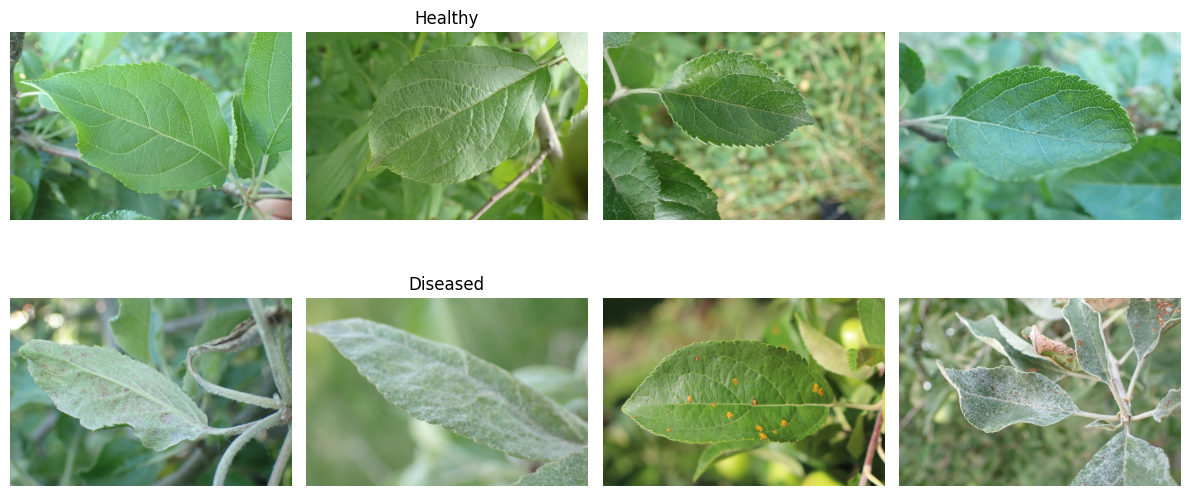

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def show_binary_samples(base_split_path, num_images=4):
    categories = {
        "Healthy": os.path.join(base_split_path, "Healthy"),
        "Diseased": []
    }
    for dis in diseased_labels:
        categories["Diseased"].append(os.path.join(base_split_path, dis))

    plt.figure(figsize=(num_images * 3, 2 * 3))

    for i, (label, paths) in enumerate(categories.items()):
        if label == "Diseased":
            all_images = []
            for dis_path in paths:
                all_images.extend([os.path.join(dis_path, f) for f in os.listdir(dis_path)])
        else:
            all_images = [os.path.join(paths, f) for f in os.listdir(paths)]

        sampled = random.sample(all_images, num_images)
        for j, img_path in enumerate(sampled):
            img = mpimg.imread(img_path)
            plt.subplot(2, num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 1:
                plt.title(label)

    plt.tight_layout()
    plt.show()

# Example from training set
show_binary_samples(os.path.join(path, "Train/Train"))


---
# Splitting of Data

In [ ]:
import os
import shutil

# Original dataset paths
original_base = path  # from kagglehub
splits = {
    'train': 'Train/Train',
    'test': 'Test/Test',
    'val': 'Validation/Validation'
}
healthy_class = 'Healthy'
diseased_classes = ['Rust', 'Powdery']

# New base path
binary_base = os.path.join(original_base, "binary_dataset")

for split, split_rel_path in splits.items():
    for category in ['Healthy', 'Diseased']:
        os.makedirs(os.path.join(binary_base, split, category), exist_ok=True)

    for cls in [healthy_class] + diseased_classes:
        cls_path = os.path.join(original_base, split_rel_path, cls)
        target_label = "Healthy" if cls == healthy_class else "Diseased"
        target_path = os.path.join(binary_base, split, target_label)

        if not os.path.exists(cls_path):
            continue

        for fname in os.listdir(cls_path):
            src = os.path.join(cls_path, fname)
            dst = os.path.join(target_path, fname)
            shutil.copyfile(src, dst)

print(f"✅ Binary dataset prepared at: {binary_base}")


✅ Binary dataset prepared at: /root/.cache/kagglehub/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/versions/1/binary_dataset


# Augmentation

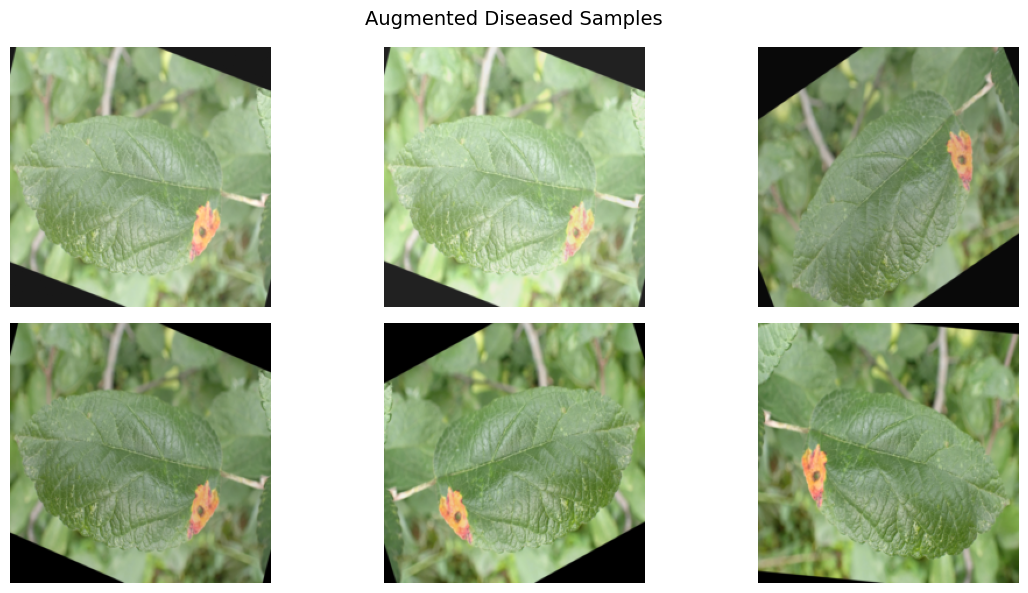

In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

# Sample path
sample_dir = os.path.join(binary_base, 'train', 'Diseased')
sample_img_path = os.path.join(sample_dir, random.choice(os.listdir(sample_dir)))
img = Image.open(sample_img_path)

# Define transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

# Apply & show
plt.figure(figsize=(12, 6))
for i in range(6):
    augmented = transform(img)
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented.permute(1, 2, 0))
    plt.axis('off')
plt.suptitle("Augmented Diseased Samples", fontsize=14)
plt.tight_layout()
plt.show()


---

# PyTorch DataLoader Setup

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [ ]:
binary_data_root = "/root/.cache/kagglehub/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/versions/1/binary_dataset"


In [ ]:
# For training: augmentations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

# For test/val: no augmentation, just resize and normalize
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [ ]:
train_data = datasets.ImageFolder(os.path.join(binary_data_root, 'train'), transform=train_transforms)
val_data = datasets.ImageFolder(os.path.join(binary_data_root, 'val'), transform=val_transforms)
test_data = datasets.ImageFolder(os.path.join(binary_data_root, 'test'), transform=val_transforms)


In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
# Print class to index mapping
print(train_data.class_to_idx)  # {'Diseased': 0, 'Healthy': 1} or vice versa


{'Diseased': 0, 'Healthy': 1}


# Benchmark: Logistic Regression with Raw Pixel Features

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from PIL import Image
import os

# Resize images and flatten for ML input
def load_images_flattened(folder, label, size=(64, 64)):
    X, y = [], []
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        img = Image.open(path).resize(size).convert('L')  # grayscale
        X.append(np.array(img).flatten())
        y.append(label)
    return X, y

X_train, y_train = [], []
for label, class_name in enumerate(['Healthy', 'Diseased']):
    folder = os.path.join(binary_data_root, 'train', class_name)
    X, y = load_images_flattened(folder, label)
    X_train += X
    y_train += y

clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Evaluate on test set
X_test, y_test = [], []
for label, class_name in enumerate(['Healthy', 'Diseased']):
    folder = os.path.join(binary_data_root, 'test', class_name)
    X, y = load_images_flattened(folder, label)
    X_test += X
    y_test += y

y_pred = clf.predict(X_test)
print("Baseline Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))


Baseline Logistic Regression Accuracy: 0.44666666666666666


# ResNet18 Training

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 pretrained on ImageNet
model = models.resnet18(pretrained=True)

# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Binary: output single logit

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
from tqdm import tqdm
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.float().to(device)
                labels = labels.unsqueeze(1)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = (torch.sigmoid(outputs) > 0.5).float()
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = correct / total
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print(f"{phase} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


In [ ]:
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

train_model(model, dataloaders, criterion, optimizer, num_epochs=5)


Epoch 1/5
train Loss: 0.0712, Accuracy: 0.9728
val Loss: 0.0293, Accuracy: 0.9833
Epoch 2/5
train Loss: 0.0707, Accuracy: 0.9720
val Loss: 0.0232, Accuracy: 1.0000
Epoch 3/5
train Loss: 0.0665, Accuracy: 0.9773
val Loss: 0.0220, Accuracy: 1.0000
Epoch 4/5
train Loss: 0.0762, Accuracy: 0.9705
val Loss: 0.0218, Accuracy: 1.0000
Epoch 5/5
train Loss: 0.0628, Accuracy: 0.9766
val Loss: 0.1019, Accuracy: 0.9500


# Plot Training vs Validation Accuracy and Loss

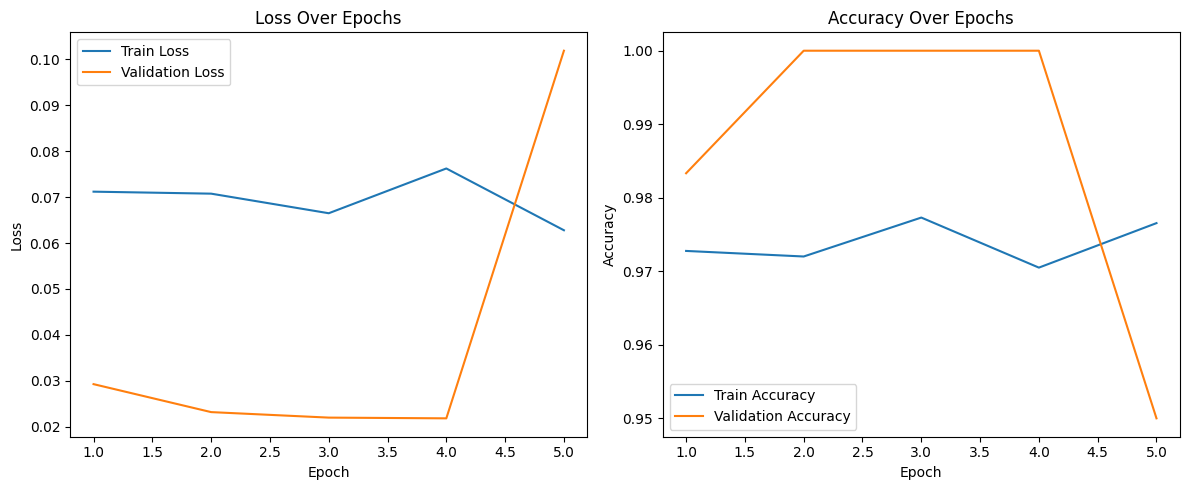

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate on Test Set

              precision    recall  f1-score   support

    Diseased       1.00      0.94      0.97       100
     Healthy       0.89      1.00      0.94        50

    accuracy                           0.96       150
   macro avg       0.95      0.97      0.96       150
weighted avg       0.96      0.96      0.96       150



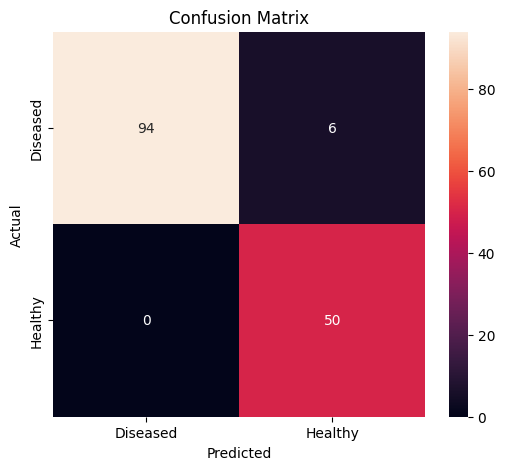

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int).flatten()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Report
print(classification_report(all_labels, all_preds, target_names=['Diseased', 'Healthy']))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Diseased', 'Healthy'], yticklabels=['Diseased', 'Healthy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
